In [14]:
import numpy as np
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt

In [5]:
file_list = listdir('./daily_data')
file_list_sub = file_list[0:2]

first = True
for file in file_list:
    coin_name = file.split("-")[0]
    if first:
        price_df = pd.read_csv('./daily_data/' + file)
        price_df['coin'] = coin_name
        first = False
    else:
        new_df = pd.read_csv('./daily_data/' + file)
        new_df['coin'] = coin_name
        price_df = price_df.append(new_df)

price_df = price_df.drop('Unnamed: 0', 1)
price_df

/var/folders/gp/0bstcdf92msf4b130ztx6zs00000gn/T/ipykernel_44521/3682714427.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price_df = price_df.drop('Unnamed: 0', 1)


,Date,Open,High,Low,Close,Volume,coin
0,2021-11-06,40.7200,49.1900,42.3200,46.1800,4.142865e+04,RGT
1,2021-11-05,37.5000,85.0000,43.7300,42.3200,3.073486e+05,RGT
2,2021-11-04,40.0000,51.0300,42.5700,43.7300,7.422225e+04,RGT
3,2021-11-03,37.3000,43.0800,39.2200,42.5900,2.482469e+04,RGT
4,2021-11-02,36.4800,40.7600,38.5200,39.1800,4.033969e+04,RGT
...,...,...,...,...,...,...,...
0,2021-11-06,0.3409,0.3899,0.3632,0.3834,5.864123e+06,LCX
1,2021-11-05,0.3050,0.4097,0.3960,0.3643,2.873723e+07,LCX
2,2021-11-04,0.3725,0.4660,0.4116,0.3974,3.562709e+07,LCX
3,2021-11-03,0.3895,0.5800,0.4867,0.4117,7.834613e+07,LCX


In [50]:
length_of_listing = price_df[['coin', 'Date']].groupby(by = 'coin').count()
length_of_listing = length_of_listing.nlargest(10, 'Date')

coins_to_trade = length_of_listing.index.to_list()

price_df = price_df[price_df['coin'].isin(coins_to_trade)]
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df_open = price_df[['Date', 'coin', 'Close']]
price_df_open = price_df.drop_duplicates()

price_df_long = price_df_open.pivot(index = 'Date', columns = 'coin', values = 'Close').dropna()

returns = price_df_long.pct_change()
cumul_returns = (1 + returns).cumprod() - 1

abs_returns = ((price_df_long.iloc[-1] - price_df_long.iloc[0])/price_df_long.iloc[0]).rename("abs_returns")
avg_returns = returns.mean().rename("avg_returns")
std_returns = returns.std().rename("std_returns")

metric_df = pd.concat([abs_returns, avg_returns, std_returns], names=['abs_returns', 'avg_returns', 'std_returns'], axis=1)
metric_df['sharpe'] = metric_df.avg_returns / metric_df.std_returns
metric_df

,abs_returns,avg_returns,std_returns,sharpe
coin,,,,
BCH,0.457791,0.002319,0.061289,0.037842
BTC,4.495162,0.002833,0.040792,0.069453
EOS,-0.226367,0.001801,0.064603,0.027876
ETC,5.933247,0.004454,0.068255,0.065257
ETH,14.339933,0.004584,0.052376,0.087522
LINK,12.962152,0.005426,0.068474,0.079236
LTC,0.748511,0.002197,0.054905,0.040013
REP,0.527141,0.003118,0.078342,0.039805
XLM,2.377284,0.003489,0.066932,0.052125


In [34]:
cumul_returns.corr()


coin,BCH,BTC,EOS,ETC,ETH,LINK,LTC,REP,XLM,ZRX
coin,,,,,,,,,,
BCH,1.000000,0.833276,0.906056,0.834802,0.837715,0.878824,0.953622,0.844708,0.915044,0.843422
BTC,0.833276,1.000000,0.631249,0.706071,0.916352,0.936310,0.929846,0.861454,0.941789,0.909772
EOS,0.906056,0.631249,1.000000,0.740898,0.664800,0.688863,0.830222,0.716971,0.760136,0.709227
ETC,0.834802,0.706071,0.740898,1.000000,0.893443,0.741151,0.747822,0.625271,0.728799,0.625294
ETH,0.837715,0.916352,0.664800,0.893443,1.000000,0.884542,0.858870,0.748579,0.859986,0.791250
LINK,0.878824,0.936310,0.688863,0.741151,0.884542,1.000000,0.924789,0.919721,0.958697,0.937004
LTC,0.953622,0.929846,0.830222,0.747822,0.858870,0.924789,1.000000,0.881178,0.966625,0.908064
REP,0.844708,0.861454,0.716971,0.625271,0.748579,0.919721,0.881178,1.000000,0.920141,0.950242
XLM,0.915044,0.941789,0.760136,0.728799,0.859986,0.958697,0.966625,0.920141,1.000000,0.949358


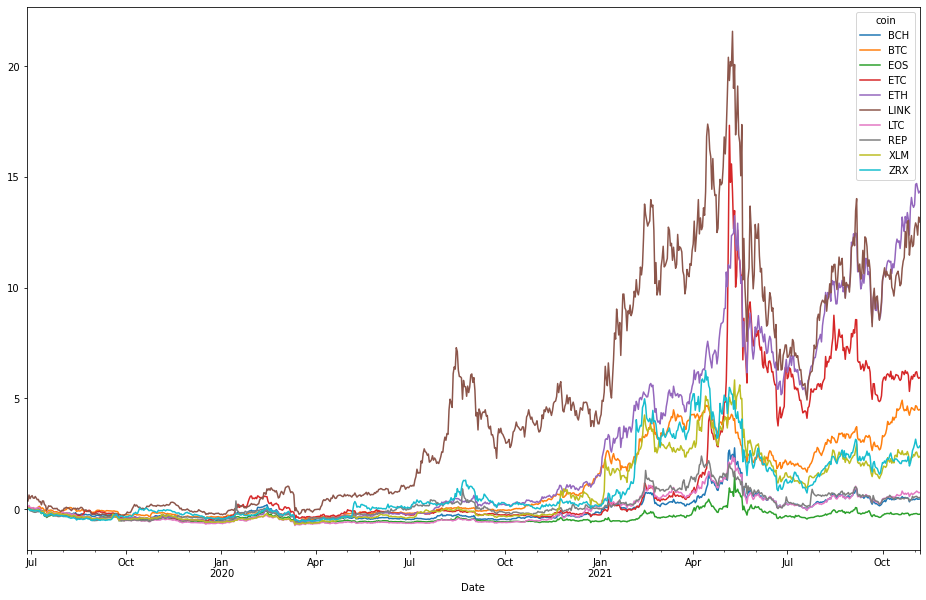

In [35]:
plt.rcParams['figure.figsize'] = [16,10]
cumul_returns.plot()
plt.show()

In [36]:
returns.std()

coin
BCH     0.061289
BTC     0.040792
EOS     0.064603
ETC     0.068255
ETH     0.052376
LINK    0.068474
LTC     0.054905
REP     0.078342
XLM     0.066932
ZRX     0.068074
dtype: float64